In [69]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import torchvision.datasets as datasets
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms

from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
import umap.umap_ as umap
from sklearn.manifold import TSNE

In [33]:
# Common transform to convert PIL image to tensor
transform = transforms.ToTensor()

# Fashion MNIST
full_fashion = ConcatDataset([
    datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform),
    datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
])

# Digit MNIST
full_mnist = ConcatDataset([
    datasets.MNIST(root='./data', train=True, download=True, transform=transform),
    datasets.MNIST(root='./data', train=False, download=True, transform=transform)
])

def dataset_to_numpy(dataset):
    images = []
    labels = []
    for img, label in dataset:
        images.append(img.numpy())  # shape: (1, 28, 28)
        labels.append(label)
    return np.array(images), np.array(labels)

mnist, y_mnist = dataset_to_numpy(full_mnist)
fashion, y_fashion = dataset_to_numpy(full_fashion)
mnist = mnist.reshape((mnist.shape[0], -1))
fashion = fashion.reshape((fashion.shape[0], -1))

#### PCA

Explained variance: [173.20604 112.91804]
Explained variance ratio: [0.22092292 0.14402606]


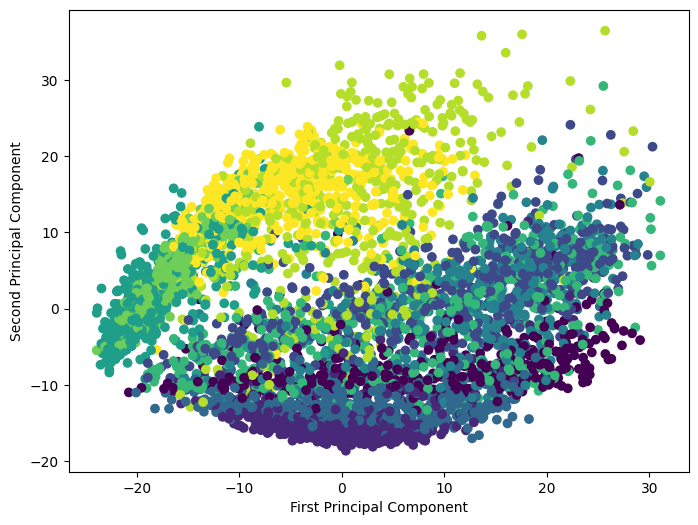

In [63]:
# PCA
pca = PCA(n_components=2)
scaled_data = StandardScaler().fit_transform(fashion)
# Fit PCA on the scaled data
pca_result = pca.fit_transform(scaled_data)

# Create a DataFrame with the PCA result
#print(pca_result)

# Explained variance measures the absolute amount of variance that is explained by each principal component. 
# This is useful when you want to know how many principal components you need to retain in order to capture a 
# certain percentage of the total variance in the original dataset.
print("Explained variance:", pca.explained_variance_)

# Explained variance ratio measures the relative amount of variance that is explained by each principal component. 
# This is useful when you want to know how much information each principal component
# contributes to the overall structure of the data.
print("Explained variance ratio:", pca.explained_variance_ratio_)

# giving a larger plot
plt.figure(figsize=(8, 6))

plt.scatter(pca_result[:5000, 0], pca_result[:5000, 1],
            c=y_fashion[:5000],  # color by labels
            cmap='viridis',  # colormap
)

# labeling x and y axes
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

#### UMAP

In [ ]:
# Create a UMAP object
reducer = umap.UMAP()
# Plot the UMAP result

c:\Users\pc\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



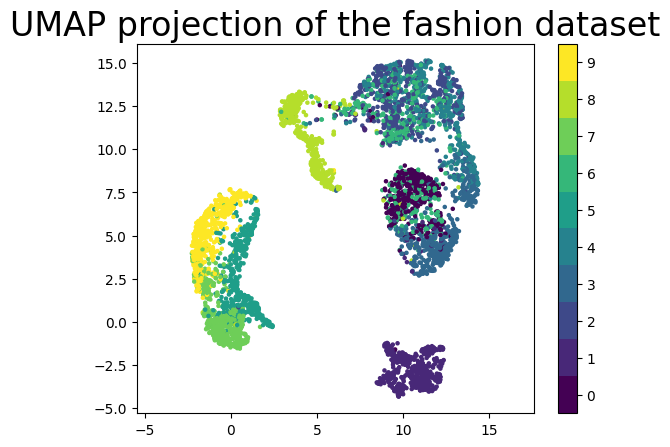

In [83]:
umap_result = reducer.fit_transform(scaled_data)
plt.scatter(umap_result[:5000, 0], umap_result[:5000, 1], c=y_fashion[:5000], cmap='viridis', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection of the fashion dataset', fontsize=24);

#### t-SNE

In [79]:
tsne = TSNE(n_components=2,perplexity=40, random_state=42)
tsne_result = tsne.fit_transform(fashion[:5000])
tsne.kl_divergence_

1.2234996557235718

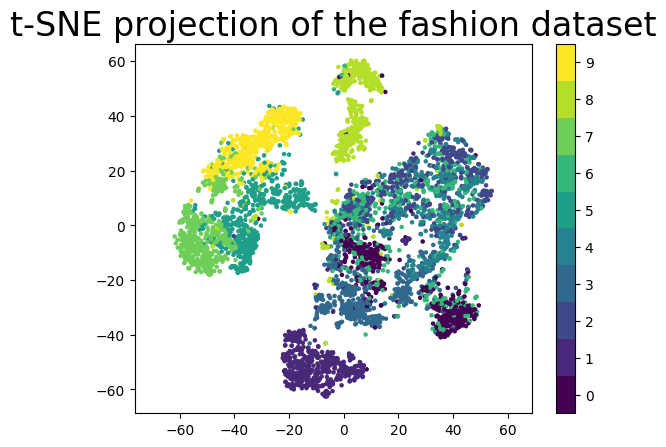

In [84]:
plt.scatter(tsne_result[:5000, 0], tsne_result[:5000, 1], c=y_fashion[:5000], cmap='viridis', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('t-SNE projection of the fashion dataset', fontsize=24);

#### VAE

In [122]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [123]:
class Autoencoder(nn.Module):
    def _init_(self, input_dim):
        super()._init_()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

def autoencoder_reduce(X):
    X_tensor = torch.tensor(X, dtype=torch.float32)
    dataset = TensorDataset(X_tensor, X_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    model = Autoencoder(X.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()

    for epoch in range(20):
        for xb, yb in dataloader:
            optimizer.zero_grad()
            recon = model(xb)
            loss = criterion(recon, yb)
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        encoded = model.encode(X_tensor).numpy()
    return encoded

In [ ]:
vae_result = autoencoder_reduce((fashion[:5000], y_fashion[:5000]))
plt.scatter(vae_result[:, 0], vae_result[:, 1], c=y_fashion[:5000], cmap='viridis', s=5)

C:\Users\pc\AppData\Local\Temp\ipykernel_13388\3093695571.py:28: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)



TypeError: not a sequence